In [1]:
using Statistics
using StableRNGs
using JSON

using Plots
using POMDPs
using POMDPTools
using CompressedBeliefMDPs

using ExpFamilyPCA

size(beliefs) = (22, 200)


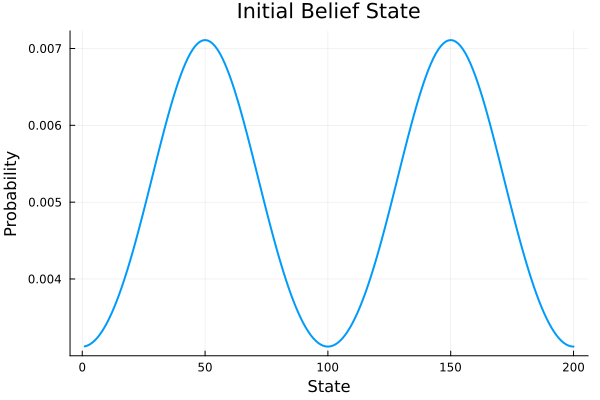

In [2]:
rng = StableRNG(123)

function is_terminal_belief(belief)
    return all(x -> x == 0, belief[1:end-1]) && belief[end] == 1
end

function drop_terminal_beliefs(B)
    B_numerical = make_numerical(B, pomdp)
    B_numerical = filter(row -> !is_terminal_belief(row), eachrow(B_numerical))  # exclude belief in terminal state
    B_numerical = reduce(hcat, B_numerical)'
    B_numerical = B_numerical[:, 1:end - 1]
    return B_numerical
end

pomdp = CircularMaze(2, 100)
policy = RandomPolicy(pomdp; rng = rng)
sampler = PolicySampler(pomdp; policy = policy, rng = rng, n = 40)
beliefs = drop_terminal_beliefs(sampler(pomdp))

@show size(beliefs)

x = 1:length(states(pomdp)) - 1
b1 = beliefs[1, :]
plot(x, b1, linestyle=:solid, linewidth=2, legend=false)
xlabel!("State")
ylabel!("Probability")
title!("Initial Belief State")

In [3]:
n, indim = size(beliefs)
outdim = 10

pca = GaussianEPCA(indim, outdim)
A1 = ExpFamilyPCA.fit!(pca, beliefs; verbose=true);

Iteration: 1/100 | Loss: 1.299369502458129e-5
Iteration: 10/100 | Loss: 2.304775099760299e-6
Iteration: 20/100 | Loss: 1.8199172869543208e-6
Iteration: 30/100 | Loss: 1.5690874082344062e-6
Iteration: 40/100 | Loss: 1.3759525135080477e-6
Iteration: 50/100 | Loss: 1.1790873935199694e-6
Iteration: 60/100 | Loss: 1.0522867153442143e-6
Iteration: 70/100 | Loss: 9.755699821460041e-7
Iteration: 80/100 | Loss: 8.968560338202808e-7
Iteration: 90/100 | Loss: 8.276599621458573e-7
Iteration: 100/100 | Loss: 8.195384326053782e-7


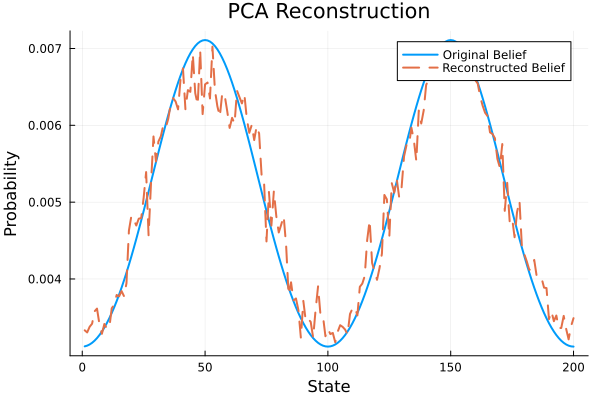

In [4]:
recon1 = decompress(pca, A1)
plot(x, b1, linestyle=:solid, linewidth=2, label="Original Belief")
plot!(x, recon1[1, :], linestyle=:dash, linewidth=2, label="Reconstructed Belief")
xlabel!("State")
ylabel!("Probability")
title!("PCA Reconstruction")
plot!(legend=true)

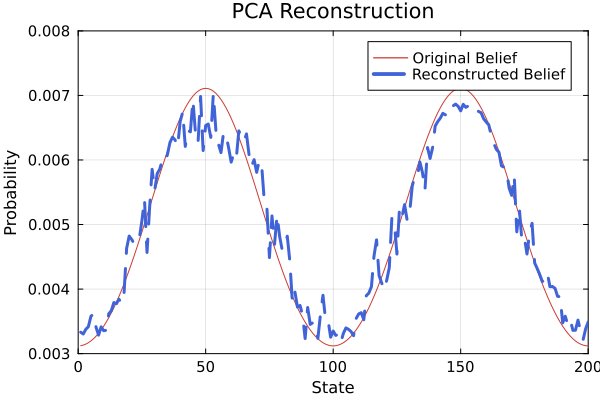

In [5]:
logocolors = Colors.JULIA_LOGO_COLORS

recon1 = decompress(pca, A1)
plot(x, b1, 
     linestyle=:solid, 
     linewidth=1, 
     color=logocolors.red,
     label="Original Belief"
)

plot!(x, recon1[1, :], 
     linestyle=:dash, 
     linewidth=3, 
     color=logocolors.blue,
     label="Reconstructed Belief"
)

xlabel!("State", fontsize=12)
ylabel!("Probability", fontsize=12)
title!("PCA Reconstruction", fontsize=14)

xlims!(0, 200)
ylims!(0.003, 0.008)

plot!(legend=:topright, legendfontsize=10, framestyle=:box)
p1 = plot!(xtickfontsize=10, ytickfontsize=10)

In [6]:
epca = PoissonEPCA(indim, outdim)
A2 = ExpFamilyPCA.fit!(epca, beliefs; verbose=true);

Iteration: 1/100 | Loss: 0.6646703242931276
Iteration: 10/100 | Loss: 0.6604007924532633
Iteration: 20/100 | Loss: 0.6603991560498623
Iteration: 30/100 | Loss: 0.6603982053545974
Iteration: 40/100 | Loss: 0.6603976590597974
Iteration: 50/100 | Loss: 0.6603973838382584
Iteration: 60/100 | Loss: 0.6603972853469737
Iteration: 70/100 | Loss: 0.6603971669193561
Iteration: 80/100 | Loss: 0.6603971148216803
Loss converged early. Stopping iteration.


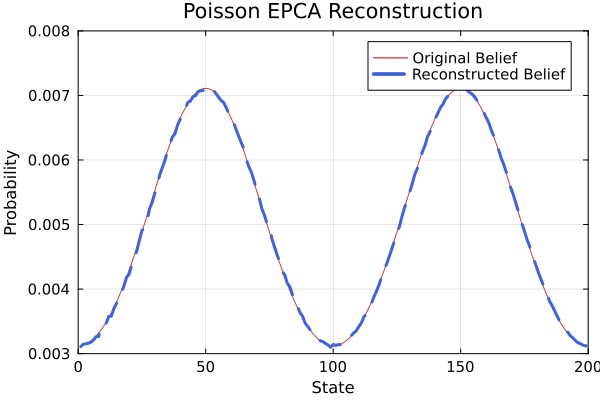

In [7]:
recon2 = decompress(epca, A2)
plot(x, b1, 
     linestyle=:solid, 
     linewidth=1, 
     color=logocolors.red,
     label="Original Belief"
)

plot!(x, recon2[1, :], 
      linestyle=:dash, 
      linewidth=3, 
      color=logocolors.blue,
      label="Reconstructed Belief"
)

xlabel!("State", fontsize=12)
ylabel!("Probability", fontsize=12)
title!("Poisson EPCA Reconstruction", fontsize=14)

xlims!(0, 200)
ylims!(0.003, 0.008)

plot!(legend=:topright, legendfontsize=10, framestyle=:box)
p2 = plot!(xtickfontsize=10, ytickfontsize=10)

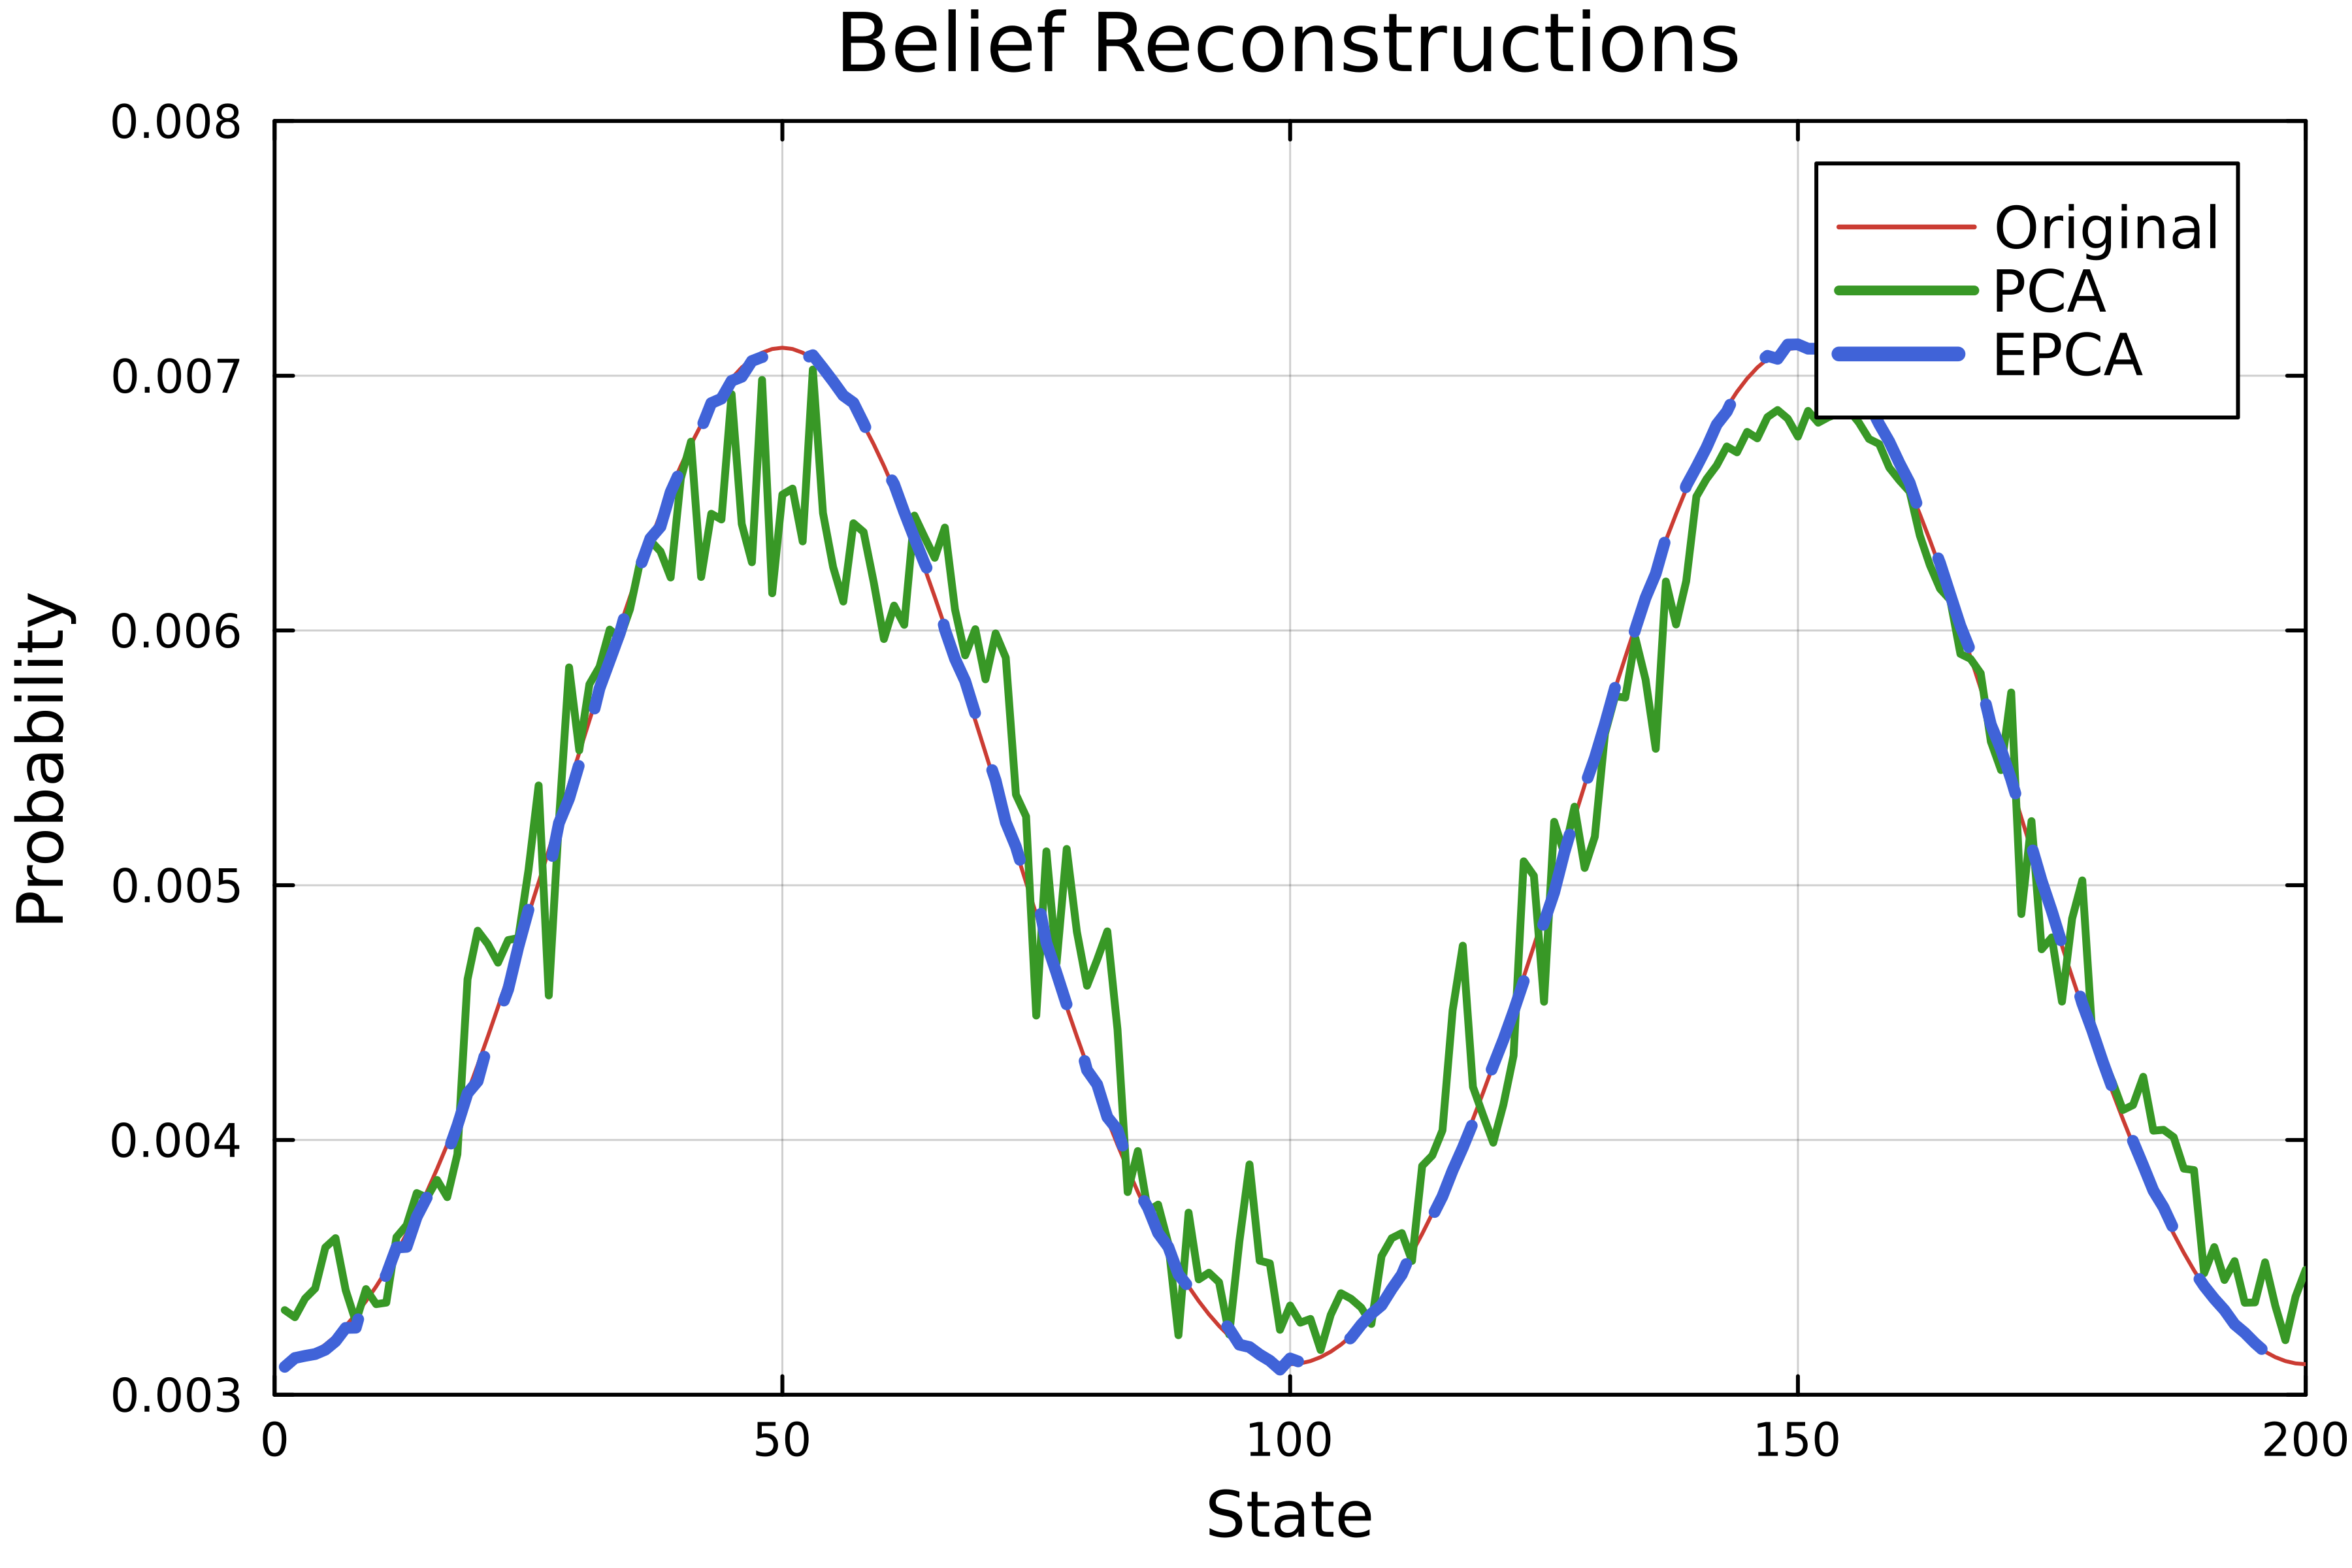

In [8]:
recon2 = decompress(epca, A2)
plot(x, b1, 
     linestyle=:solid, 
     linewidth=1, 
     color=logocolors.red,
     label="Original",
     dpi=600
)

plot!(x, recon1[1, :], 
      linestyle=:solid, 
      linewidth=2, 
      color=logocolors.green,
      label="PCA",
      dpi=600
)

plot!(x, recon2[1, :], 
      linestyle=:dash, 
      linewidth=3, 
      color=logocolors.blue,
      label="EPCA",
      dpi=600
)

label_size = 8
tick_size = 8
xlabel!("State", fontsize=label_size)
ylabel!("Probability", fontsize=label_size)
title!("Belief Reconstructions", fontsize=14)

xlims!(0, 200)
ylims!(0.003, 0.008)

plot!(legend=:topright, legendfontsize=10, framestyle=:box)
figure2 = plot!(xtickfontsize=tick_size, ytickfontsize=tick_size)

In [9]:
savefig("reconstructions.png")

"/Users/logan/Documents/VSCodeProjects/BeliefCompression/ExpFamilyPCA/scripts/reconstructions.png"

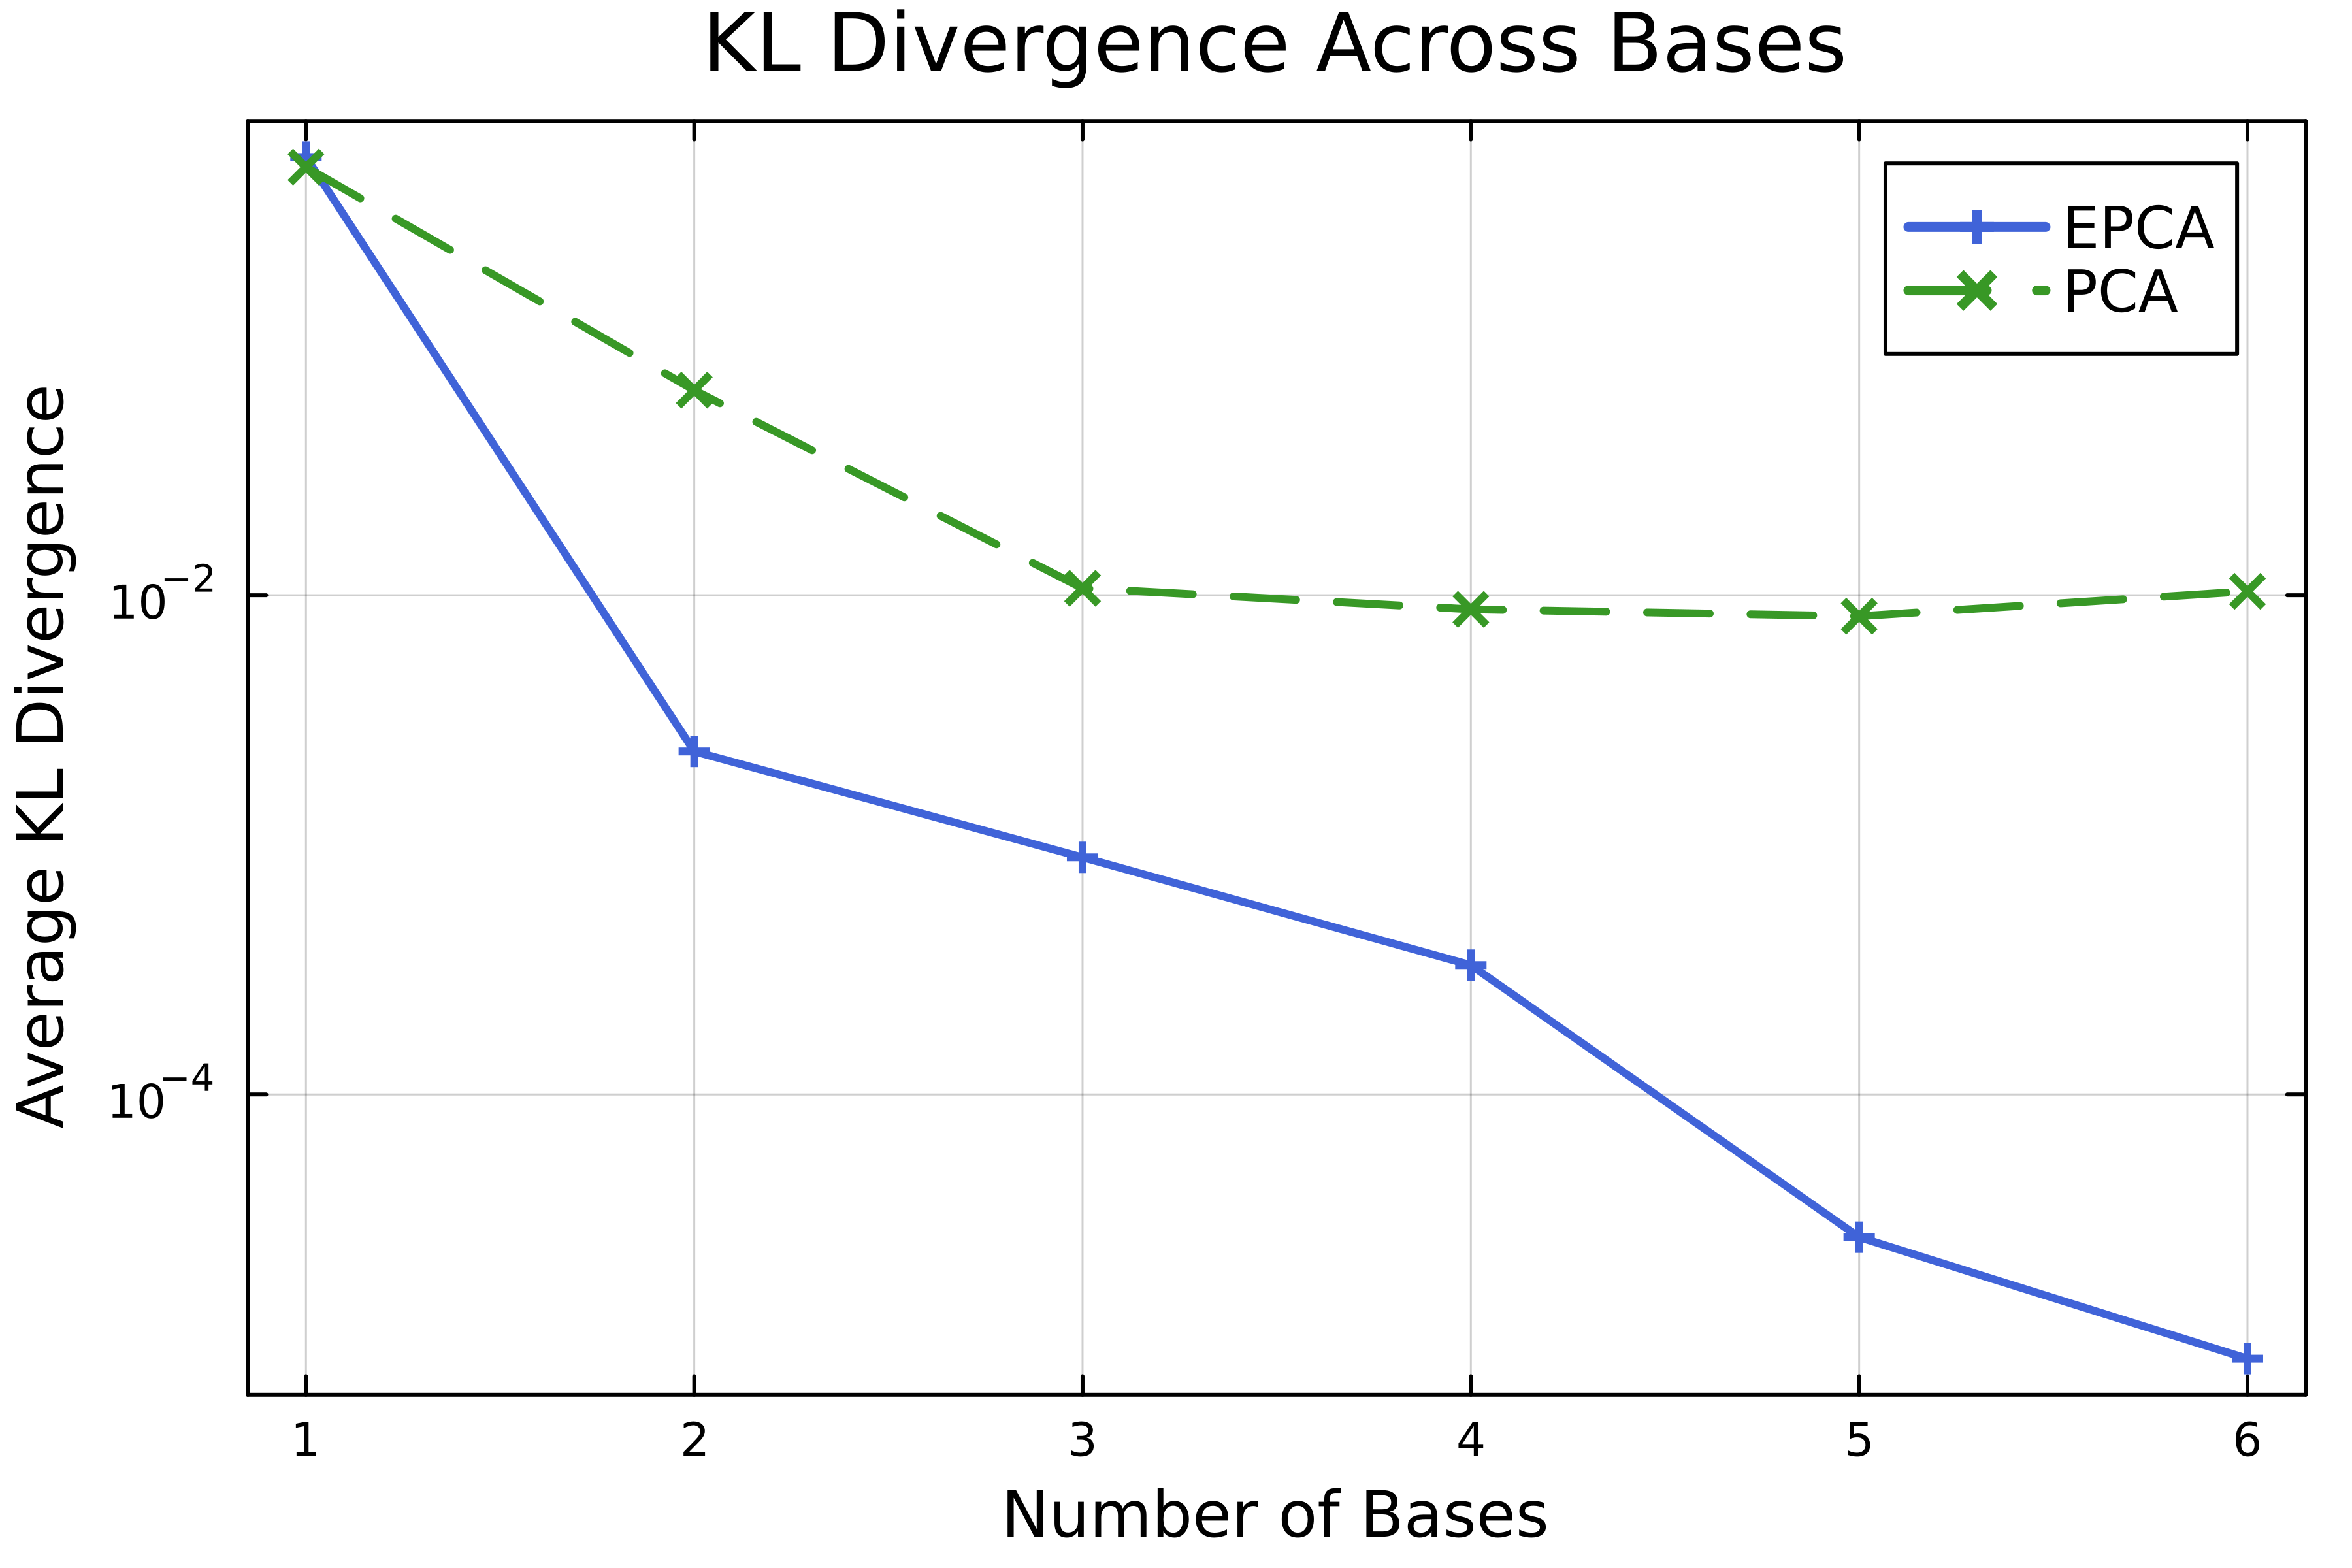

In [10]:
epca_data = Dict(parse(Int, k) => v for (k, v) in JSON.parsefile("jsons/epca_data.json"))
pca_data = Dict(parse(Int, k) => v for (k, v) in JSON.parsefile("jsons/pca_data.json"))

kl_divs_poisson_epca = []
kl_divs_gaussian_epca = []

outdims = 1:6
for k in outdims
    push!(kl_divs_poisson_epca, mean(epca_data[k]))
    push!(kl_divs_gaussian_epca, mean(pca_data[k]))
end

plot(
    outdims, 
    kl_divs_poisson_epca, 
    label="EPCA", 
    color=logocolors.blue,
    yscale=:log10,
    marker=:cross, 
    linestyle=:solid, 
    lw=2,
    dpi=600
)
plot!(
    outdims, 
    kl_divs_gaussian_epca, 
    label="PCA",
    yscale=:log10,
    color=logocolors.green,
    marker=:x,
    linestyle=:dash,
    lw=2,
    dpi=600

)
title!("KL Divergence Across Bases", fontsize=14)
xlabel!("Number of Bases", fontsize=label_size)
ylabel!("Average KL Divergence", fontsize=label_size)
figure1 = plot!(
    legendfontsize = 10,
    xtickfontsize = tick_size,
    ytickfontsize = tick_size,
    framestyle = :box,
    aspectration = :equal,
    markerstrokewidth = 2,  # Makes markers more prominent
    markeralpha = 0.7  # Adds transparency to markers
)

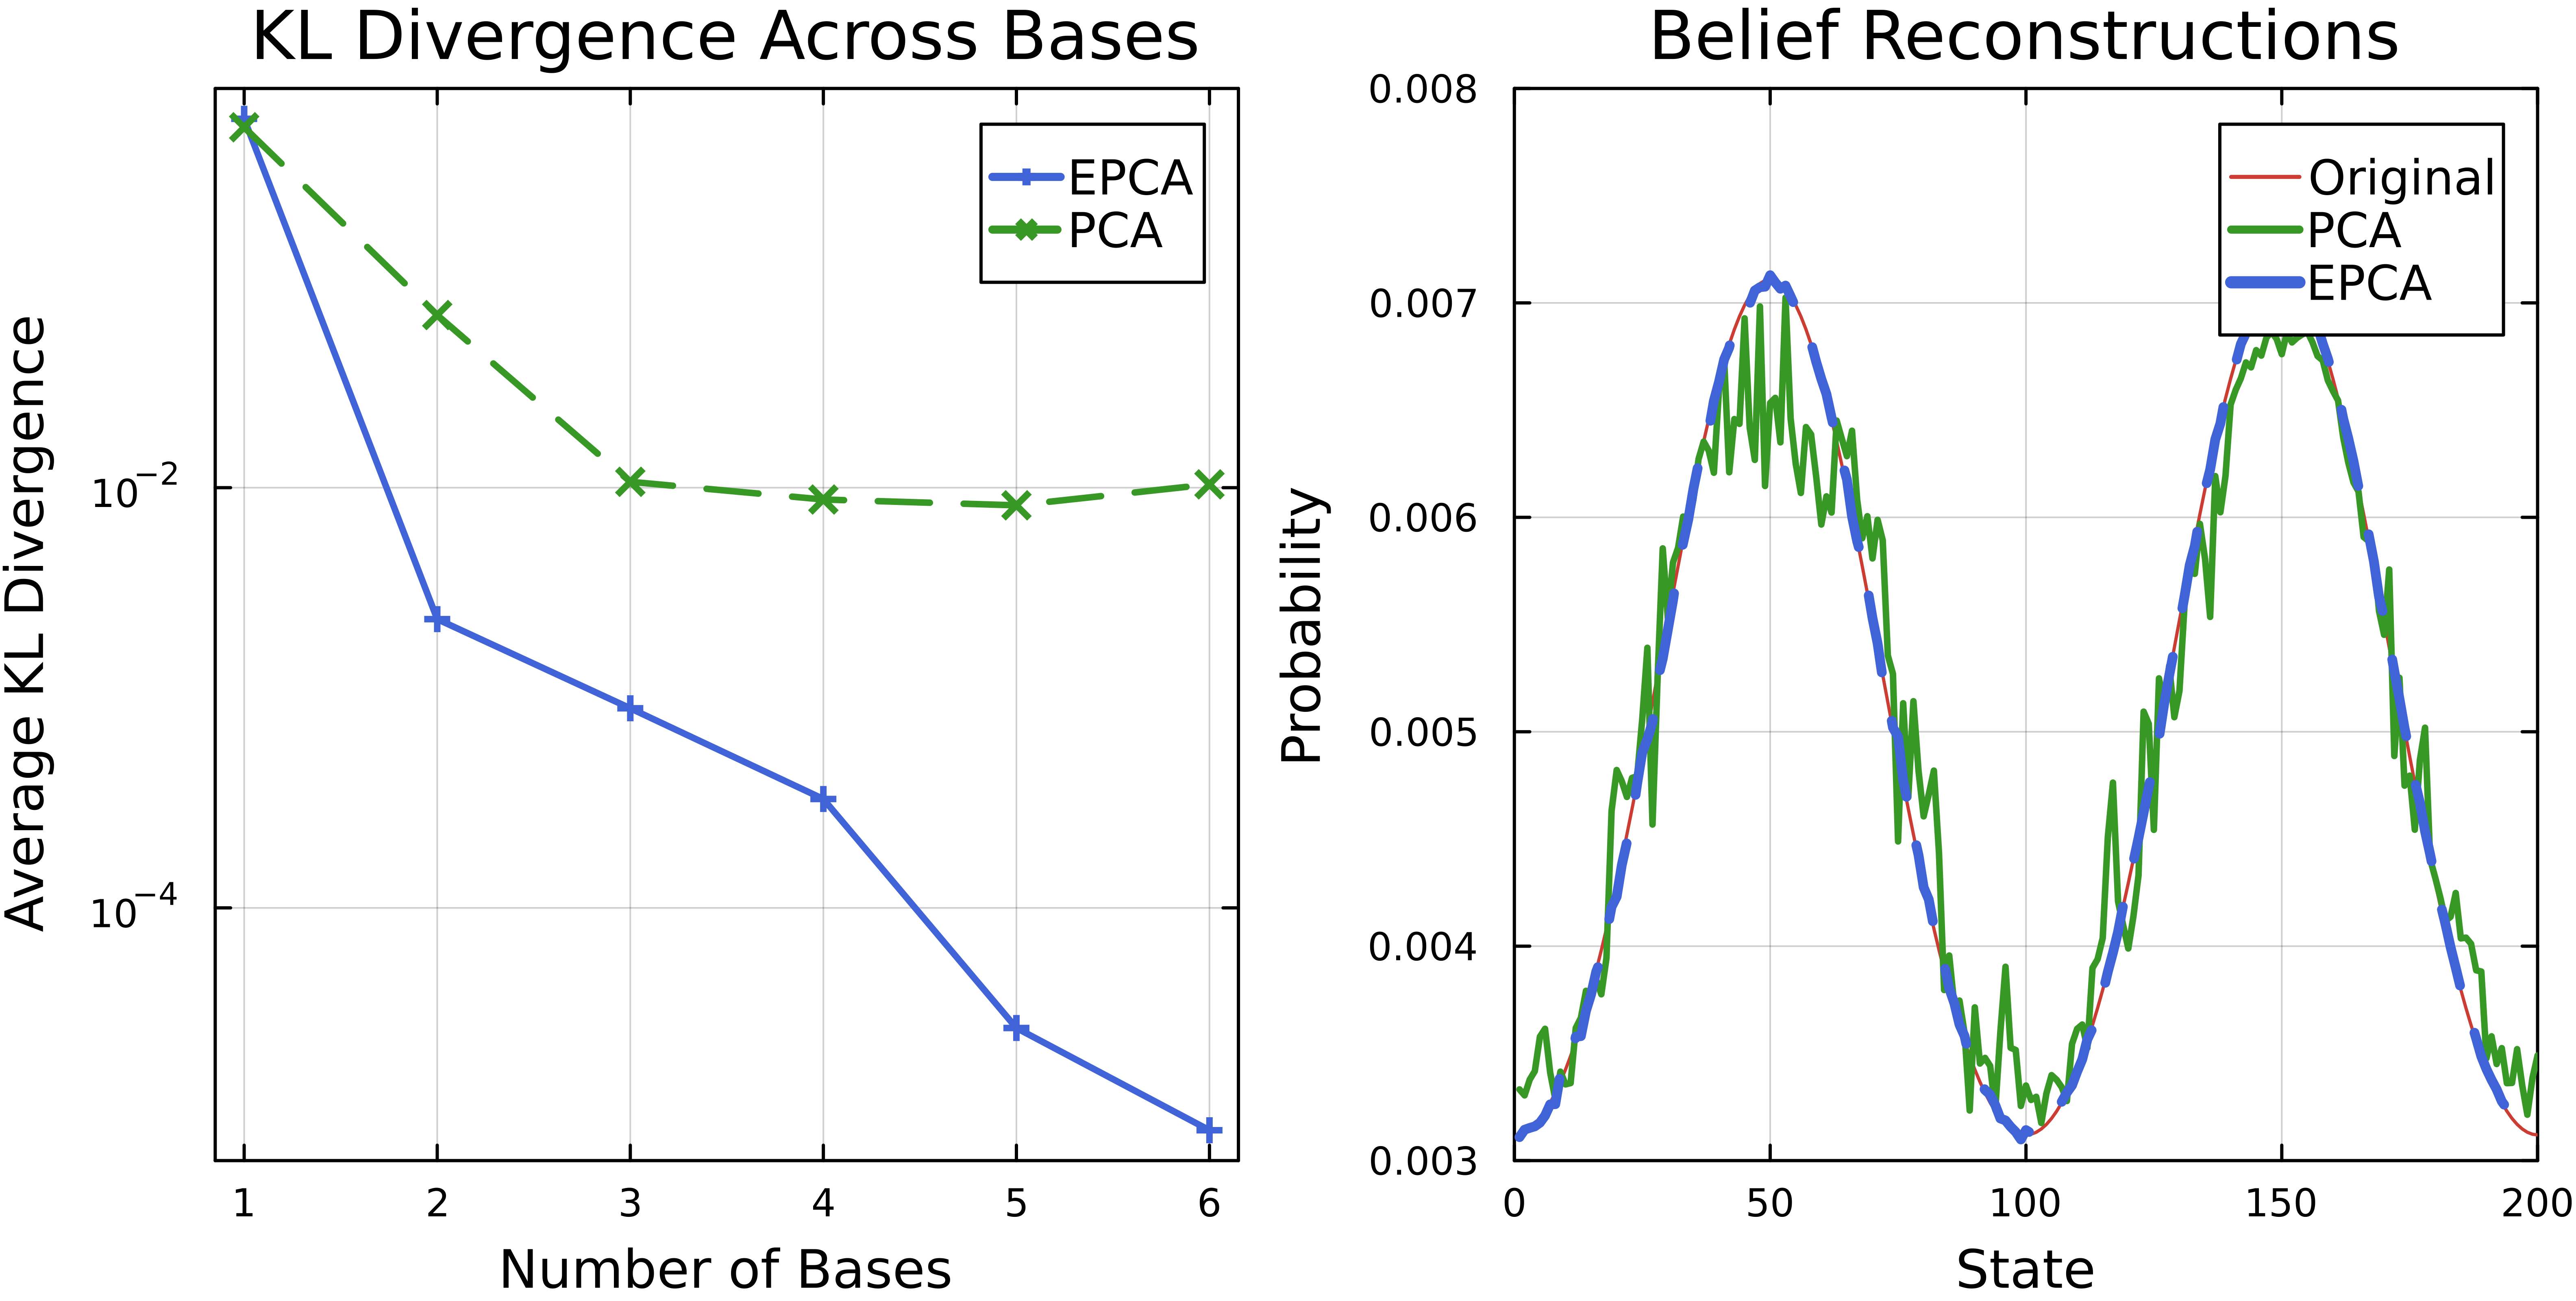

In [11]:
page_length_in_pixels = 11 * 72  # 11 inches at 72 DPI ~ 800 pixels
combined_plot = plot(figure1, figure2, layout = (1, 2),  size = (page_length_in_pixels, 400), left_margin = 2 * Plots.mm, bottom_margin = 2 * Plots.mm, dpi=800)

In [12]:
savefig("combo.png")

"/Users/logan/Documents/VSCodeProjects/BeliefCompression/ExpFamilyPCA/scripts/combo.png"